# McUtils

This notebook tracks the most up to date version of `McUtils`.
Test data is also available.

In [2]:
import sys, os
sys.path.insert(0, os.path.dirname(os.getcwd()))

In [3]:
import os
import McUtils

test_dir = os.path.join(os.path.dirname(os.path.dirname(McUtils.__file__)), 'ci', 'tests', 'TestData')
def test_data(name):
    return os.path.join(test_dir, name)

## Examples

_This content is borrowed directly from [the docs](https://mccoygroup.github.io/McUtils/McUtils)_

We will provide a brief examples for the common use cases for each module.
More information can be found on the pages themselves.
The unit tests for each package are provided on the bottom of the package page.
These provide useful usage examples.

## Parsers

The `Parsers` package provides a toolkit for easily parsing string data out of files.

In [10]:
from McUtils.Parsers import *

Here we'll get every key-value pair matching the pattern `key = value` from a Gaussian `.log` file

In [11]:
with open(test_data('water_OH_scan.log')) as log_dat:
    sample_data = log_dat.read()

key_value_matcher = RegexPattern([Named(Word, "key"), "=", Named(Word, "value")])
key_vals = StringParser(key_value_matcher).parse_all(sample_data)
key_vals['key'].array

array(['0', 'Input', 'Output', ..., 'State', 'RMSD', 'PG'], dtype='<U7')

It's used extensively in the `GaussianInterface` package.

## Plots

A layer on `matplotlib` to provide more declarative syntax and easier composability.

In [12]:
from McUtils.Plots import *

Here we'll make a styled `GraphicsGrid`

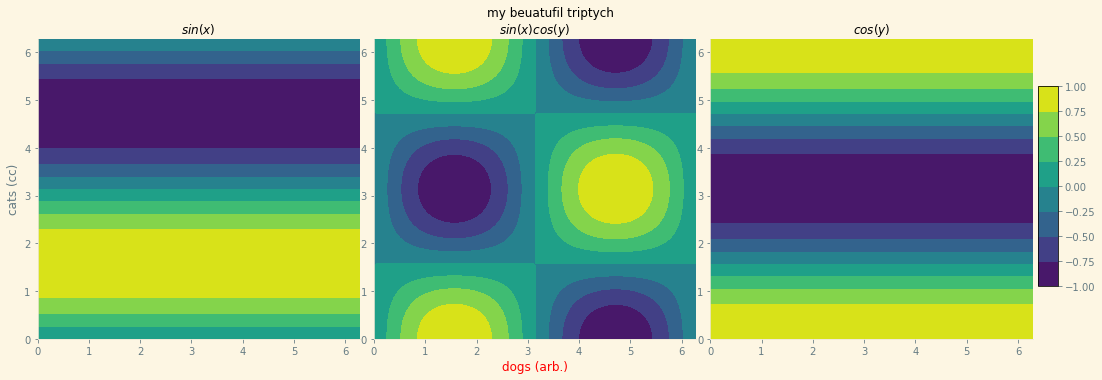

In [15]:
import numpy as np

grid = np.linspace(0, 2 * np.pi, 100)
grid_2D = np.meshgrid(grid, grid)
x = grid_2D[1]
y = grid_2D[0]

main = GraphicsGrid(ncols=3, nrows=1, theme='Solarize_Light2', figure_label='my beuatufil triptych',
                            padding=((35, 60), (35, 40)), subimage_size=(300, 300)
                   )
main[0, 0] = ContourPlot(x, y, np.sin(y), plot_label='$sin(x)$',
                         axes_labels=[None, "cats (cc)"],
                         figure=main[0, 0]
                         )
main[0, 1] = ContourPlot(x, y, np.sin(x) * np.cos(y),
                         plot_label='$sin(x)cos(y)$',
                         axes_labels=[Styled("dogs (arb.)", {'color': 'red'}), None],
                         figure=main[0, 1])
main[0, 2] = ContourPlot(x, y, np.cos(y), plot_label='$cos(y)$', figure=main[0, 2])
main.colorbar = {"graphics": main[0, 1].graphics}

## Data

Provides access to relevant atomic/units data pulled from NIST databases.

In [16]:
from McUtils.Data import *

Pull the record for deuterium

In [17]:
AtomData["D"]

DataRecord('D', AtomDataHandler('AtomData', file='None'))

Grab the isotopically correct atomic mass

In [18]:
AtomData["D", "Mass"]

2.01410177812

Get all possible keys

In [19]:
AtomData["D"].keys()

dict_keys(['Name', 'Symbol', 'Mass', 'Number', 'MassNumber', 'IsotopeFraction', 'CanonicalName', 'CanonicalSymbol', 'ElementName', 'ElementSymbol', 'IconColor', 'IconRadius', 'PrimaryIsotope', 'StandardAtomicWeights'])

Get the conversion from Hartrees to wavenumbers

In [20]:
UnitsData.convert("Hartrees", "Wavenumbers")

219474.6313632

This conversion is not in the underlying database but is computed implicitly.

Another example: here we first query the direct conversion

In [21]:
UnitsData.data[("AtomicMassUnits", "Wavenumbers")]

KeyError: ('AtomicMassUnits', 'Wavenumbers')

But we are still able to find a chain of conversions that will allow us to convert the two units

In [22]:
UnitsData.convert("AtomicMassUnits", "Wavenumbers")

7513006610400.0

This routes through the fact that there is a known conversion between amu and $E_h$

In [23]:
UnitsData.data[("AtomicMassUnits", "Hartrees")]

{'Value': 34231776.874,
 'Uncertainty': 0.01,
 'Conversion': ('AtomicMassUnits', 'Hartrees')}

## Coordinerds

Provides utilities for writing coordinate conversions and obtaining Jacobians between coordinate systems.

In [24]:
from McUtils.Coordinerds import *

First we make a set of Cartesian coordinates

In [26]:
struct = [
            [ 0.0,                    0.0,                   0.0                ],
            [ 0.5312106220949451,     0.0,                   0.0                ],
            [ 5.4908987527698905e-2,  0.5746865893353914,    0.0                ],
            [-6.188515885294378e-2,  -2.4189926062338385e-2, 0.4721688095375285 ],
            [ 1.53308938205413e-2,    0.3833690190410768,    0.23086294551212294],
            [ 0.1310095622893345,     0.30435650497612,      0.5316931774973834 ]
        ]
coords = CoordinateSet(struct)
coords

CoordinateSet([[ 0.        ,  0.        ,  0.        ],
               [ 0.53121062,  0.        ,  0.        ],
               [ 0.05490899,  0.57468659,  0.        ],
               [-0.06188516, -0.02418993,  0.47216881],
               [ 0.01533089,  0.38336902,  0.23086295],
               [ 0.13100956,  0.3043565 ,  0.53169318]])

then we convert that to Z-matrix coordinates

In [34]:
icrds = coords.convert(ZMatrixCoordinates, ordering = [
    [0, -1, -1, -1],
    [1,  0, -1, -1],
    [2,  1,  0, -1],
    [3,  2,  1,  0],
    [4,  2,  1,  0],
    [5,  2,  1,  0]
])
icrds

CoordinateSet([[ 0.53121062,  0.        ,  0.        ],
               [ 0.74641002,  0.878738  ,  0.        ],
               [ 0.77151626,  1.04598737, -0.7854913 ],
               [ 0.30243435,  1.15540698, -0.98685875],
               [ 0.60130465,  1.12973263, -1.35974392]])

We can also directly back-convert

In [30]:
icrds.convert(coords.system)

CoordinateSet([[ 0.        ,  0.        ,  0.        ],
               [ 0.53121062,  0.        ,  0.        ],
               [ 0.05490899,  0.57468659,  0.        ],
               [-0.06188516, -0.02418993,  0.47216881],
               [ 0.01533089,  0.38336902,  0.23086295],
               [ 0.13100956,  0.3043565 ,  0.53169318]])

We can also get the Jacobian for the transformation

In [45]:
jac = coords.jacobian(ZMatrixCoordinates, converter_options=dict(
    ordering = [
        [0, -1, -1, -1],
        [1,  0, -1, -1],
        [2,  1,  0, -1],
        [3,  2,  1,  0],
        [4,  2,  1,  0],
        [5,  2,  1,  0]
    ]
))
[
    jac.shape,
    jac[0]
]

[(6, 3, 5, 3),
 array([[[-1.        ,  0.        ,  0.        ],
         [ 0.        , -0.        ,  0.        ],
         [ 0.        ,  0.        ,  0.        ],
         [ 0.        ,  0.        ,  0.        ],
         [ 0.        ,  0.        ,  0.        ]],
 
        [[ 0.        ,  0.        ,  0.        ],
         [ 0.        , -1.88249248,  0.        ],
         [ 0.        ,  0.        ,  0.        ],
         [ 0.        ,  0.        ,  0.        ],
         [ 0.        ,  0.        ,  0.        ]],
 
        [[ 0.        ,  0.        ,  0.        ],
         [ 0.        , -0.        ,  0.        ],
         [ 0.        ,  0.        ,  2.44500443],
         [ 0.        ,  0.        ,  2.44500443],
         [ 0.        ,  0.        ,  2.44500443]]])]

## Zachary

Zachary is a higher-level package than `Numputils` and handles all numerical/tensor operations.

In [4]:
from McUtils.Zachary import *

It's become something of a monster but is very useful.

1D finite difference derivative via [finite_difference](Zachary/FiniteDifferenceFunction/finite_difference.md):

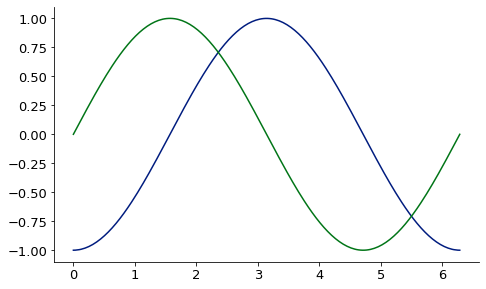

In [57]:
import numpy as np
sin_grid = np.linspace(0, 2*np.pi, 200)
sin_vals = np.sin(sin_grid)

deriv = finite_difference(sin_grid, sin_vals, 3) # 3rd deriv
base = Plot(sin_grid, deriv, aspect_ratio=.6, image_size=500)
Plot(sin_grid, np.sin(sin_grid), figure=base)

2D finite difference derivative via [finite_difference](Zachary/FiniteDifferenceFunction/finite_difference.md):

In [9]:
from McUtils.Jupyter import ModuleReloader
ModuleReloader('McUtils').reload()
from McUtils.Zachary import *
from McUtils.Plots import *

In [5]:
from McUtils.Plots import *
import numpy as np

In [ ]:
from McUtils.Jupyter import ModuleReloader
ModuleReloader('McUtils').reload()
from McUtils.Zachary import *
from McUtils.Plots import *

x_grid = np.linspace(0, 2*np.pi, 200)
y_grid = np.linspace(0, 2*np.pi, 100)
sin_x_vals = np.sin(x_grid); sin_y_vals =  np.sin(y_grid)
vals_2D = np.outer(sin_x_vals, sin_y_vals)
grid_2D = np.array(np.meshgrid(x_grid, y_grid)).T

deriv = finite_difference(grid_2D, vals_2D, (1, 3))
TensorPlot(np.array([vals_2D, deriv]), image_size=500, aspect_ratio=1)